# Regional Error Detection at the Californian Coast

This notebook will plot, analyze, and clarify errors between satellite and saildrone data for sea surface salinity (SSS) and sea surface temperature (SST).

**When, where, why are differences largest?**

### Part 1. Select a region and aggregate data

We will chart data on the california coast.

In [1]:
import sys
from colorama import Fore
from colorama import Back

import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr

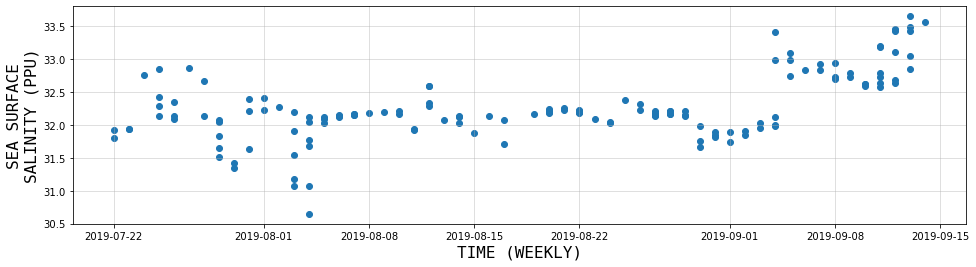

Filtered between 30 and 35 PPU


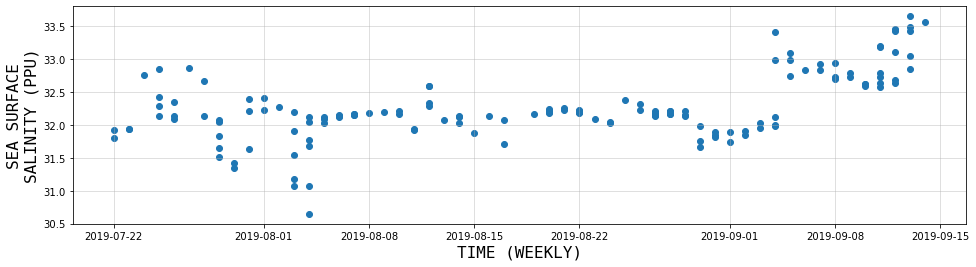

In [2]:
%run "../Project 3 - Clean Anomalies/CleanAnomalies-SingleFunction.ipynb"
sail = cleanAnomalies("../../saildrone_data/saildrone_west_coast_survey_2019_sd1044_JPLv5.0_8dy_20210613norep_20210613_20211116.nc")

sat_smap_sss - satellite

SAL_CTD_MEAN - saildrone

#### Detect outliers and set constraints

**For Standard Deviation Method (Uncomment Bottom Box):**
- Range (stDevRange) is the number of standard deviations from the mean to consider an outlier.
- The default is 1 and presents a good handful of clear outliers in the data.
- However, many statistical samples generally consider the range for a valid outlier to be 2.5 to 3 standard deviations from the mean.
- Here, one standard deviation is plenty to represent the differences in the data - because the innacuracies are quite visible already.

In [6]:
satData = sail['sat_smap_sss'] # change to sat_anc_sst for temperature
seaData = sail['SAL_CTD_MEAN'] # change to analyzed_sst for temperature

quantileRange = 0.1

qt = len(seaData)

# we store the data in a 2d array to later rebuild into a dataframe
data = [[], [], [], []]

for x in range(qt):
    diff = abs(satData[x] - seaData[x])
    data[0].append(float(sail.lon[x]))
    data[1].append(float(sail.lat[x]))
    data[2].append(float(diff))
    data[3].append(x) # index in sail[]

differences = pd.DataFrame({'lon': data[0], 'lat': data[1], 'diff': data[2]})
    
# filter out based on quartiles
less = differences.quantile(0 + quantileRange)[2]
more = differences.quantile(1 - quantileRange)[2]
print(str(less) + ", " + str(more))

safeValues = 0
for x in range(qt):
    diff = differences['diff'][x]
    if (diff < more and diff > less): # if our number is within the safe range
        # do nun, it's safe!
        differences = differences.drop(x) # we DROP IT!
        print("Dropped value " + str(diff) + " out of DataFrame")
    else: # if it isn't
        safeValues += 1
        
# sort the index so they go from 0-xxx without any holes
differences = differences.reset_index(drop = True)

0.06427253873572739, 0.7386538586425785
Dropped value 0.07360566068950192 out of DataFrame
Dropped value 0.09477600624276761 out of DataFrame
Dropped value 0.6257567328121922 out of DataFrame
Dropped value 0.6801703607570388 out of DataFrame
Dropped value 0.2070203786600544 out of DataFrame
Dropped value 0.09186331751696741 out of DataFrame
Dropped value 0.1329529033045631 out of DataFrame
Dropped value 0.1590575998364585 out of DataFrame
Dropped value 0.11095829508126798 out of DataFrame
Dropped value 0.5287381561539632 out of DataFrame
Dropped value 0.2231856673041861 out of DataFrame
Dropped value 0.25864452030242546 out of DataFrame
Dropped value 0.204993499755858 out of DataFrame
Dropped value 0.5641884676709594 out of DataFrame
Dropped value 0.5569349105592742 out of DataFrame
Dropped value 0.30897006346156175 out of DataFrame
Dropped value 0.5988836289760009 out of DataFrame
Dropped value 0.4717830521960771 out of DataFrame
Dropped value 0.5109054743602215 out of DataFrame
Dropp

In [5]:
# stDevRange = 1

# stDev = float(sail['sat_smap_sss'].std()) * stDevRange

# satData = sail['sat_smap_sss'] # change to sat_anc_sst for temperature
# seaData = sail['SAL_CTD_MEAN'] # change to analyzed_sst for temperature

# qt = len(seaData)

# # we store the data in a 2d array to later rebuild into a dataframe
# data = [[], [], [], []]

# for x in range(qt):
#     diff = abs(satData[x] - seaData[x])
#     if (diff > stDev):
#         print("Outlier with Diff " + str(float(diff)))
#         data[0].append(float(sail.lon[x]))
#         data[1].append(float(sail.lat[x]))
#         data[2].append(float(diff))
#         data[3].append(x) # index in sail[]

# differences = pd.DataFrame({'lon': data[0], 'lat': data[1], 'diff': data[2]})
# differences

### Part 2. Plotting the Differences Data

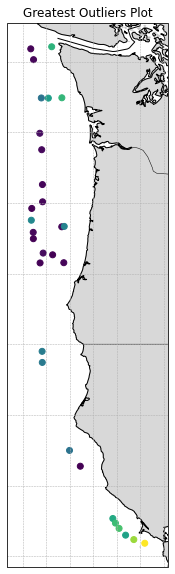

In [6]:
fig = plt.figure(figsize=(16,10), dpi = 72)
ax = plt.axes(projection=ccrs.PlateCarree())

#define latitude and longitude boundaries
latr = [np.min(differences['lat']), np.max(differences['lat'])] 
lonr = [np.max(differences['lon']), np.min(differences['lon'])] 

# Select a region of our data, giving it a margin
margin = 0.5 
region = np.array([[latr[0]-margin,latr[1]+margin],[lonr[0]+margin,lonr[1]-margin]]) 

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.coastlines(resolution='10m',linewidth=1,color='black')
ax.add_feature(cfeature.LAND, color='grey', alpha=0.3)
ax.add_feature(states_provinces, linewidth = 0.5)
ax.add_feature(cfeature.BORDERS, color = 'black')
ax.set_extent([region[1,0],region[1,1],region[0,0],region[0,1]],crs=ccrs.PlateCarree()) 
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.gridlines(linestyle = '--', linewidth = 0.5)

#plot diff data
plt.title("Greatest Outliers Plot")
plt.scatter(differences.lon, differences.lat, c = differences['diff'])

plt.show()

### Quickly summarize some of our new data

In [7]:
diffs = differences['diff']

greatest = sys.float_info.min;
least = sys.float_info.max;
total = 0
for x in range(len(diffs)):
    if (diffs[x] > greatest):
        greatest = diffs[x]
    if (diffs[x] < least):
        least = diffs[x]
    total += diffs[x]
    
avg = total / len(diffs)
print(Back.RESET + "Least significant outlier differed by " + Back.RED + str(least))
print(Back.RESET + "Most significant outlier differed by " + Back.GREEN + str(greatest))
print(Back.RESET + "Range of differences was " + Back.YELLOW + str(greatest - least))
print(Back.RESET + "Average difference " + Back.BLUE + str(avg))

Least significant outlier differed by 0.0015180236816405568
Most significant outlier differed by 1.9524183177859271
Range of differences was 1.9509002941042866
Average difference 0.5854716785124088


### Plot and compare against similar data in the same regions.

#### Leading Questions:
- Do they face the same innacuracies?
- What causes these differences?
- What relationships can we build between SSS/SST and other variables?

#### **In this simple example:**
##### We will plot the significance of a data innacuracy with the distance to land, to see if there is a correlation.

In [7]:
sail

<xarray.Dataset>
Dimensions:                       (time: 145)
Coordinates:
    trajectory                    float32 ...
  * time                          (time) datetime64[ns] 2019-07-22T01:16:30 ....
    ob                            (time) int64 ...
Data variables: (12/41)
    lat                           (time) float64 ...
    lon                           (time) float64 ...
    SOG_MEAN                      (time) float64 ...
    COG_MEAN                      (time) float64 ...
    HDG_MEAN                      (time) float64 ...
    ROLL_MEAN                     (time) float64 ...
    ...                            ...
    sat_lon                       (time) float64 ...
    dist_land                     (time) float64 ...
    analysed_sst                  (time) float64 ...
    analysis_error                (time) float64 ...
    mask                          (time) float64 ...
    sea_ice_fraction              (time) float64 ...
Attributes: (12/45)
    area:                      Pacific Ocean
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, ACDD-1.3, COARDS
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_end:         2019-09-16T19:57:00Z
    time_coverage_resolution:  PT1M
    time_coverage_start:       2019-06-18T00:00:00Z
    title:                     Saildrone West Coast Survey 2019
    Westernmost_Easting:       -125.970752
    vehicle_id:                sd1044

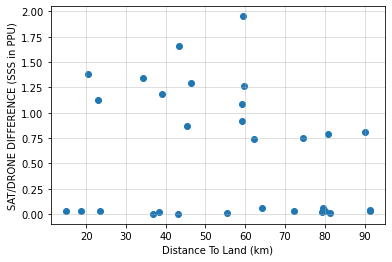

In [8]:
# xAxis will be distance to land
# yAxis will be difference level
xSample = []
xSampleName = "Distance To Land (km)"

for x in range(len(diffs)):
    indexInSail = data[3][x]
    xSample.append(sail['dist_land'][indexInSail])

#create plot 
plt.figure()
plt.scatter(x = xSample, y = diffs) #seaborn has built in confidence intervals
# make temp/sal plot
#add labels

plt.grid(zorder=0, alpha=0.5)
plt.xlabel(xSampleName)
plt.ylabel('SAT/DRONE DIFFERENCE (SSS in PPU)')
plt.show()

# 20 Graphs of DOOM!
#### We are going to plot six graphs representing the data above.
##### FOR SSS:
- Y: SSS, X: DIST LAND
- Y: SSS, X: SST
- Y: SSS, X: WIND SPEED (Pyth Theorem of U and V)

##### FOR SST:
- Y: SST, X: DIST LAND
- Y: SST, X: SSS
- Y: SSS, X: WIND SPEED

In [11]:
def drawGraph(xVal, yVal, xName, yName):
    plt.figure()
    plt.scatter(x = xVal, y = yVal)
    plt.grid(zorder=0, alpha=0.5)
    plt.xlabel(xName)
    plt.ylabel(yName)
    plt.show()

In [9]:
#author: gammon
#create function for calculating windspeed
def windspeed(u, v):
    return np.sqrt((np.abs(u**2) + np.abs(v**2)))

#calculate windspeed using function
sail['wind_speed'] = windspeed(sail['UWND_MEAN'], sail['VWND_MEAN'])

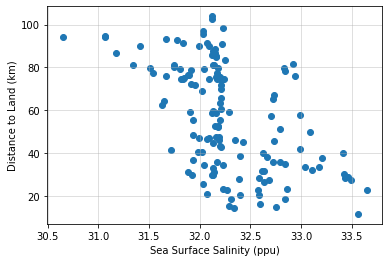

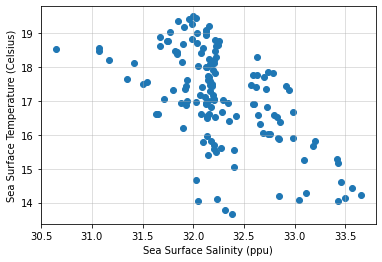

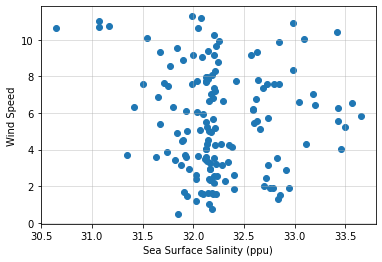

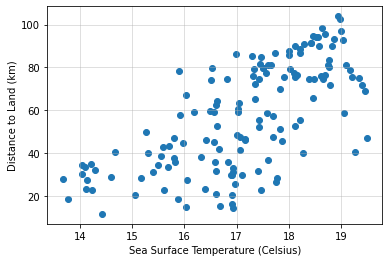

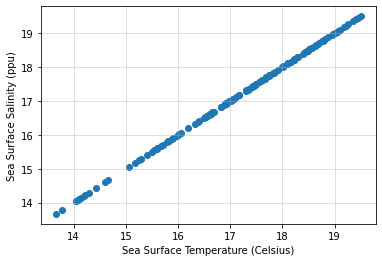

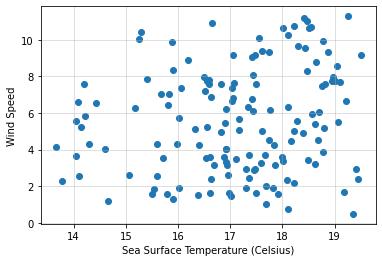

In [14]:
dist_land = sail['dist_land']
sst = sail['analysed_sst']
sss = sail['SAL_CTD_MEAN']
wind_speed = sail['wind_speed']

# magic celsius function
def celsify(array):
    return [x - 273.15 for x in array]

sst = celsify(sst)

# SSS
drawGraph(sss, dist_land, "Sea Surface Salinity (ppu)", "Distance to Land (km)")
drawGraph(sss, sst, "Sea Surface Salinity (ppu)", "Sea Surface Temperature (Celsius)")
drawGraph(sss, wind_speed, "Sea Surface Salinity (ppu)", "Wind Speed")

# SST
drawGraph(sst, dist_land, "Sea Surface Temperature (Celsius)", "Distance to Land (km)")
drawGraph(sst, sst, "Sea Surface Temperature (Celsius)", "Sea Surface Salinity (ppu)")

drawGraph(sst, wind_speed, "Sea Surface Temperature (Celsius)", "Wind Speed")